# Task 1: Word Embeddings (10 points)

This notebook will guide you through all steps necessary to train a word2vec model (Detailed description in the PDF).

## Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages)

In [1]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
print("Done")

Done


# 1.1 Get the data (0.5 points)

The Hindi portion HASOC corpus from [github.io](https://hasocfire.github.io/hasoc/2019/dataset.html) is already available in the repo, at data/hindi_hatespeech.tsv . Load it into a data structure of your choice. Then, split off a small part of the corpus as a development set (~100 data points).

If you are using Colab the first two lines will let you upload folders or files from your local file system.

In [2]:
# Selecting GPU if available
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
    
url = 'https://raw.githubusercontent.com/salmanedhi/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv'

print("Done", dev)

Done cuda:0


In [9]:
# Getting complete Hindi Dataset
url = 'https://raw.githubusercontent.com/salmanedhi/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv'

data = pd.read_csv(url, sep='\t')
data_development = data
type(data_development['task_1'])

print(data_development)

            text_id                                               text task_1  \
0     hasoc_hi_5556  बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...    NOT   
1     hasoc_hi_5648  सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...    HOF   
2      hasoc_hi_164  तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...    HOF   
3     hasoc_hi_3530  बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...    NOT   
4     hasoc_hi_5206  चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...    NOT   
...             ...                                                ...    ...   
4660  hasoc_hi_6606  पाकिस्तान ने हिंदुओं के ख़िलाफ़ बोलने वाले को ...    NOT   
4661  hasoc_hi_4931  कोहली है #नेहरू नहीं जो अंग्रेजों के तलवे चाटन...    HOF   
4662  hasoc_hi_1059      परशुराम? वही जिसने अपनी मां की हत्या की थीं?     NOT   
4663  hasoc_hi_5429  जिस देश में #कन्हैया_कुमार जैसा पढ़ा लिखा युवा...    HOF   
4664  hasoc_hi_1656  इनके बापों मैं भी दम नहीं जो भारत को इस्लामिक ...    HOF   

     task_2 task_3  
0     

## 1.2 Data preparation (0.5 + 0.5 points)

* Prepare the data by removing everything that does not contain information. 
User names (starting with '@') and punctuation symbols clearly do not convey information, but we also want to get rid of so-called [stopwords](https://en.wikipedia.org/wiki/Stop_word), i. e. words that have little to no semantic content (and, but, yes, the...). Hindi stopwords can be found [here](https://github.com/stopwords-iso/stopwords-hi/blob/master/stopwords-hi.txt) Then, standardize the spelling by lowercasing all words.
Do this for the development section of the corpus for now.

* What about hashtags (starting with '#') and emojis? Should they be removed too? Justify your answer in the report, and explain how you accounted for this in your implementation.

In [4]:
# Removing stopwords

hindi_stopword_file = open('data/stopwords-hi.txt', encoding="utf8")

sw_list = ['#', '?', '!', ';', ',', ':', "\'", '-', '=', '(', ')', '[', ']' , '{', '}', '"', '*', '@', '  ', '\\', '/', '..', '...', '....', '%'
          ,'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\t']
sw_list_string = ''
for i in sw_list:
    sw_list_string+=i
hindi_stopwords = []
for x in hindi_stopword_file:
    hindi_stopwords.append(x.rstrip())

hindi_stopwords.extend(sw_list)
sentences = []
for text in data_development['text']:
    text_array = text.split(' ')
    new_array = []
    for j in text_array:
        if '@' not in j and len(j) < 20:
            for char in sw_list:
                j = j.replace(char, '')
            new_array.append(j.lower())
    sentences.append(' '.join(new_array))

print("Done")

Done


## 1.3 Build the vocabulary (0.5 + 0.5 points)

The input to the first layer of word2vec is an one-hot encoding of the current word. The output od the model is then compared to a numeric class label of the words within the size of the skip-gram window. Now

* Compile a list of all words in the development section of your corpus and save it in a variable ```V```.

In [5]:
# Creating vocabulary of words
temp_unique = [] # For unique words
temp_nounique = []
for j in sentences:
    temp2 = j.split(' ')
    for k in temp2:
        if k not in temp_unique:
            temp_unique.append(k)
        temp_nounique.append(k)
V = temp_unique
non_unique = temp_nounique
print('Total words:', len(non_unique))
print('Unique words:', len(V))

Total words: 141550
Unique words: 19836


* Then, write a function ```word_to_one_hot``` that returns a one-hot encoding of an arbitrary word in the vocabulary. The size of the one-hot encoding should be ```len(v)```.

In [6]:

# takes word as input and total number of words, and created one hot encoding of that word
def word_to_one_hot(word, features):
    if word in V:
        index = V.index(word)
        encoding = np.zeros(features)
        encoding[index]= 1
        return encoding.astype(np.uint8)
    return False

# Returns index of word in vocabulary
def not_word_to_one_hot(word, features):
    if word in V:
        index = V.index(word)
        return index
    return False

## 1.4 Subsampling (0.5 points)

The probability to keep a word in a context is given by:

$P_{keep}(w_i) = \Big(\sqrt{\frac{z(w_i)}{0.001}}+1\Big) \cdot \frac{0.001}{z(w_i)}$

Where $z(w_i)$ is the relative frequency of the word $w_i$ in the corpus. Now,
* Calculate word frequencies
* Define a function ```sampling_prob``` that takes a word (string) as input and returns the probabiliy to **keep** the word in a context.

In [7]:
def sampling_prob(word):
    z_wi = non_unique.count(word) / len(non_unique)
    try:
        p_wi = (mt.sqrt(z_wi / 0.001) + 1) * (0.001 / z_wi)
        return p_wi
    except ZeroDivisionError:
        print("Word doesn't exist in corpus")
    pass

In [10]:
# Just for testing
sampling_prob('बांग्लादेश')
sample_onehot = word_to_one_hot('बांग्लादेश', len(V))
print(sample_onehot.shape)
print(sample_onehot)

(19836,)
[1 0 0 ... 0 0 0]


# 1.5 Skip-Grams (1 point)

Now that you have the vocabulary and one-hot encodings at hand, you can start to do the actual work. The skip gram model requires training data of the shape ```(current_word, context)```, with ```context``` being the words before and/or after ```current_word``` within ```window_size```. 

* Have closer look on the original paper. If you feel to understand how skip-gram works, implement a function ```get_target_context``` that takes a sentence as input and [yield](https://docs.python.org/3.9/reference/simple_stmts.html#the-yield-statement)s a ```(current_word, context)```.

* Use your ```sampling_prob``` function to drop words from contexts as you sample them. 

In [11]:
# Takes in window size and sentence to create target and context tuple
def get_target_context(sentence, window_size):
    word = ''
    words_in_sentence = sentence.split(' ')
    for i in range(len(words_in_sentence)):
        context = []
        randd = random.random()
        if randd <= sampling_prob(words_in_sentence[i]):
            word = words_in_sentence[i]
            upper_bound = i + window_size + 1
            lower_bound = i - window_size
            for j in range(lower_bound, upper_bound):
                rand2 = random.random()
                if i != j and j>=0 and j<len(words_in_sentence):
                    if rand2 <= sampling_prob(words_in_sentence[j]):
                        context.append(words_in_sentence[j])
        if len(word) > 0 and len(context) > 0:
            yield(word, context)

print("Done")

Done


# 1.6 Hyperparameters (0.5 points)

According to the word2vec paper, what would be a good choice for the following hyperparameters? 

* Embedding dimension
* Window size

Initialize them in a dictionary or as independent variables in the code block below. 

In [12]:
window_size = 4
embedding_size = 640

# More hyperparameters
learning_rate = 0.01
epochs = 50

# 1.7 Pytorch Module (0.5 + 0.5 + 0.5 points)

Pytorch provides a wrapper for your fancy and super-complex models: [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The code block below contains a skeleton for such a wrapper. Now,

* Initialize the two weight matrices of word2vec as fields of the class.

* Override the ```forward``` method of this class. It should take a one-hot encoding as input, perform the matrix multiplications, and finally apply a log softmax on the output layer.

* Initialize the model and save its weights in a variable. The Pytorch documentation will tell you how to do that.

In [13]:
# Create model 

class Word2Vec(nn.Module):
    def __init__(self, features, embedding_size):
        super().__init__()
        self.fc1 = nn.Linear(features, embedding_size)
        self.fc2 = nn.Linear(embedding_size, features)


    def forward(self, one_hot):
        x = self.fc1(one_hot.float())
        x = self.fc2(x)
        log_softmax = torch.nn.functional.log_softmax(x, dim=1)
        return log_softmax
#     pass

print("Done")

Done


# 1.8 Loss function and optimizer (0.5 points)

Initialize variables with [optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and loss function. You can take what is used in the word2vec paper, but you can use alternative optimizers/loss functions if you explain your choice in the report.

### Creating target, context tuple

In [16]:
# Creating x and y pair for training and saving them for future use

def create_dataset(sentences):
    x_train = []
    y_train = []
    count = 0
    print("started")
    for j, i in enumerate(sentences):
        if (j + 1) % 50 == 0:
            print("INDEX:", j, "Length:",len(x_train))
        word_context = get_target_context(i, window_size)
        for word, context in word_context:
            input_vec = not_word_to_one_hot(word, len(V))
            for j in context:
                output_vec = not_word_to_one_hot(j, len(V))
                x_train.append(input_vec)
                y_train.append(output_vec)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    np.save('x_train_hindi', x_train)
    np.save('y_train_hindi', y_train)
    return x_train, y_train
print(len(sentences))
x_train, y_train = create_dataset(sentences)
print(x_train.shape)

4665
started
INDEX: 49 Length: 5763
INDEX: 99 Length: 11801
INDEX: 149 Length: 18074
INDEX: 199 Length: 23901
INDEX: 249 Length: 29182
INDEX: 299 Length: 36056
INDEX: 349 Length: 43026
INDEX: 399 Length: 49027
INDEX: 449 Length: 54513
INDEX: 499 Length: 61058
INDEX: 549 Length: 67488
INDEX: 599 Length: 74382
INDEX: 649 Length: 81213
INDEX: 699 Length: 87837
INDEX: 749 Length: 94357
INDEX: 799 Length: 101828
INDEX: 849 Length: 107540
INDEX: 899 Length: 113735
INDEX: 949 Length: 121055
INDEX: 999 Length: 126681
INDEX: 1049 Length: 133371
INDEX: 1099 Length: 139038
INDEX: 1149 Length: 145709
INDEX: 1199 Length: 152016
INDEX: 1249 Length: 157403
INDEX: 1299 Length: 162902
INDEX: 1349 Length: 167591
INDEX: 1399 Length: 172549
INDEX: 1449 Length: 178246
INDEX: 1499 Length: 183985
INDEX: 1549 Length: 188529
INDEX: 1599 Length: 194461
INDEX: 1649 Length: 199520
INDEX: 1699 Length: 205833
INDEX: 1749 Length: 210883
INDEX: 1799 Length: 217149
INDEX: 1849 Length: 222267
INDEX: 1899 Length: 227599

### Loading to dataloader

In [18]:
# Loading presaved numpy array (data).
x_train = np.load('x_train_hindi.npy')
y_train = np.load('y_train_hindi.npy')
print(x_train.shape)
print(max(x_train))
print("Done")

(614572,)
19835
Done


In [19]:
print(y_train[0])
batch_size = 1000
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_train = data_utils.TensorDataset(x_train, y_train)
train_dl = DataLoader(x_train, batch_size=batch_size, shuffle=True)
features = len(V)
total_rows = len(y_train)
print(total_rows)

2
614572


# 1.9 Training the model (3 points)

As everything is prepared, implement a training loop that performs several passes of the data set through the model. You are free to do this as you please, but your code should:

* Load the weights saved in 1.6 at the start of every execution of the code block
* Print the accumulated loss at least after every epoch (the accumulate loss should be reset after every epoch)
* Define a criterion for the training procedure to terminate if a certain loss value is reached. You can find the threshold by observing the loss for the development set.

You can play around with the number of epochs and the learning rate.

Started:


<ipython-input-21-00d9cc051eae>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(y_pred_torch, torch.max(torch.tensor(y_batch), 1)[1])


Epoch: 0 	Loss: 8.19541756389587
Epoch: 1 	Loss: 7.428822573219858
Epoch: 2 	Loss: 7.192678070068359
Epoch: 3 	Loss: 7.059873238230139
Epoch: 4 	Loss: 6.969899367510788
Epoch: 5 	Loss: 6.905386175760409
Epoch: 6 	Loss: 6.853943573556295
Epoch: 7 	Loss: 6.813107047817572
Epoch: 8 	Loss: 6.776615404113522
Epoch: 9 	Loss: 6.738992171558907
Epoch: 10 	Loss: 6.7100015585984645
Epoch: 11 	Loss: 6.68120086793977
Epoch: 12 	Loss: 6.6599945928992295
Epoch: 13 	Loss: 6.636457968921196
Epoch: 14 	Loss: 6.61482912621847
Epoch: 15 	Loss: 6.605704022229203
Epoch: 16 	Loss: 6.585478501978929
Epoch: 17 	Loss: 6.57417120041886
Epoch: 18 	Loss: 6.563918624660833
Epoch: 19 	Loss: 6.55483085973476
Epoch: 20 	Loss: 6.539381245093617
Epoch: 21 	Loss: 6.534014508782364
Epoch: 22 	Loss: 6.530230622950608
Epoch: 23 	Loss: 6.524380659087886
Epoch: 24 	Loss: 6.514771000931902
Epoch: 25 	Loss: 6.509192520234643
Epoch: 26 	Loss: 6.501413726031296
Epoch: 27 	Loss: 6.4997447711665455
Epoch: 28 	Loss: 6.4984660311443

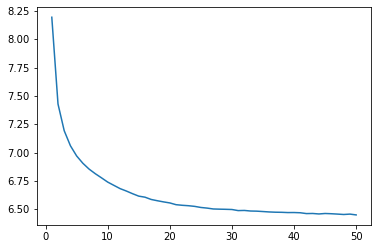

In [21]:
# Define optimizer and loss

net = Word2Vec(len(V), embedding_size)
net.to(dev)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.NLLLoss()

def train():
    print("Started:")
    loss_vals=  []
    for e in range(epochs):
        epoch_loss= []
        for i, (X_batch, y_batch) in enumerate(train_dl):
            X_batch = np.eye(len(V))[X_batch]
            y_batch = np.eye(len(V))[y_batch]
            X_batch = torch.Tensor(X_batch).to(dev)
            y_batch = torch.Tensor(y_batch).to(dev)
            y_pred_torch = net(X_batch)
            loss = criterion(y_pred_torch, torch.max(torch.tensor(y_batch), 1)[1])
            optimizer.zero_grad()
            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print('Epoch:', e,'\tLoss:',loss_vals[e])
    torch.save(net.state_dict(), 'model_param_hindi')
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
    plt.savefig('Task1_hindi.png')
train()

print("Training finished")

In [ ]:
print(y_train.shape)

# 1.10 Train on the full dataset (0.5 points)

Now, go back to 1.1 and remove the restriction on the number of sentences in your corpus. Then, reexecute code blocks 1.2, 1.3 and 1.6 (or those relevant if you created additional ones). 

* Then, retrain your model on the complete dataset.

* Now, the input weights of the model contain the desired word embeddings! Save them together with the corresponding vocabulary items (Pytorch provides a nice [functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for this).

In [ ]:
torch.save(net, 'model_finalised_bengali')

In [ ]:
torch.load('model_finalised_bengali')

In [ ]:
torch.save(net.state_dict(), 'model_param_finalised_bengali')

###### 